## Import required libraries.

In [1]:
%%capture
import operator
import seaborn as sns; sns.set()
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import medfilt
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator,LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Define required functions.

In [2]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def difference_from_mean_elevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def meanFilter(gidded_data):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = gidded_data[central_value]                        
    mean = np.nanmean(gidded_data)#Count number of values greater than centroid value
    return mean
def maxFilter(gidded_data):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = gidded_data[central_value]                        
    max_value = np.amax(gidded_data)#Count number of values greater than centroid value
    return max_value
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence

## Setup input data 
Define spatial resolution: Specify the resolution of the input DEM and also the desired working resolution (can be same as input DEM resolution).

In [3]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:/PhD/manuscript/flow_routing_algorithms/data')
os.chdir(location)
input_geotiff = gdal.Open('fann_2013_1m.tif')
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = scipy.ndimage.zoom(x, input_DEM_resolution / working_resolution, order = 1)
input_outlets = gdal.Open('core_nodes_1m.tif')
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets = o.astype('uint8')


In [4]:
p = o.astype('int32')
l = np.unique(p)

In [5]:
gh_list = l.tolist();
gh_list.remove(0);

In [6]:
len(gh_list)

1

In [71]:
input_DEM.shape

(6354, 10873)

In [72]:
gh_list

[1]

In [185]:
divergence_ids_adjusted_nodes = np.isin(grid_nodes,gh_list).astype('uint8')

In [192]:
convergence_ids_adjusted_nodes = np.isin(grid_nodes,gh_list).astype('uint8')

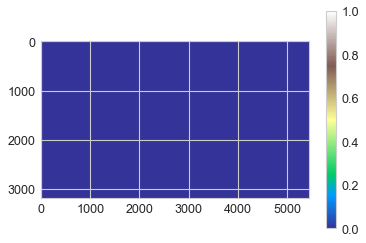

In [93]:
plt.imshow(convergence_ids_adjusted_nodes, cmap="terrain");
plt.colorbar();

## Visualise the DEM.

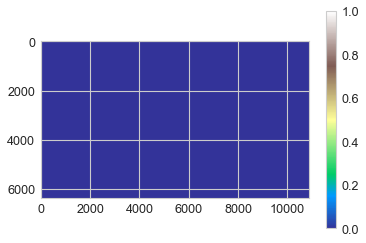

In [15]:
plt.imshow(o, cmap="terrain", vmin = np.percentile(input_DEM, 5));
plt.colorbar();

## Setup a RasterModelGrid object and assign elevation to nodes.

In [29]:
catchment_area_grids = xr.Dataset()
direction_list = ['East', 'North', 'West', 'South',
                  'North East', 'North West', 'South West', 'South East'];
#################################################################################################
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

## Find the node ID of the outlet.
Note: Outlet spatial location is given by the 'outlets' variable assigned under "Setup input data."

In [30]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))

In [31]:
grid_nodes.shape

(733, 558)

In [32]:
find_outlet_ids = grid_nodes * outlets

In [33]:
find_outlet_ids = grid_nodes * outlets
outlet_id = np.unique(find_outlet_ids)[1]
outlet_id

121312

## Fill sinks and run flow accumulation.

In [34]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
#(flow_acc, q) = fa.accumulate_flow();
fa.run_one_step()
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step()

## Show a list of values located on each node.

In [35]:
mg.at_node.keys()

['topographic__elevation',
 'sediment_fill__depth',
 'water__unit_flux_in',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'flow__receiver_proportions',
 'topographic__steepest_slope',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag']

## Assign some of the above values to variables.

In [36]:
da = np.array(mg.at_node['drainage_area'].round(4));
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
catchment_area = da.reshape(mg.shape)
frn = mg.at_node['flow__receiver_node'];
drainage_area = np.flip(da.reshape(mg.shape), 0);
wuf = np.array(mg.at_node['water__unit_flux_in']);
frp = np.array(mg.at_node['flow__receiver_proportions']);
funo = np.array(mg.at_node['flow__upstream_node_order'].reshape(mg.shape));
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0);
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
flrn = mg.at_node['flow__link_to_receiver_node'];
links_carrying_flow = flrn.reshape(flow_rec_surf_rows,8);
tss = mg.at_node['topographic__steepest_slope'];
steepest_slope = tss.reshape(flow_rec_surf_rows,8);
all_receiver_proportions = np.copy(frp);


In [37]:
da.shape

(409014,)

In [38]:
central_value = find_median_value(rectangleWindow(3,3))
num_values = number_of_values(rectangleWindow(3,3))

In [29]:
mean_catchment_area = generic_filter(catchment_area, meanFilter, 
                        footprint= rectangleWindow(3,3), mode='nearest');

In [30]:
flattened_mean_catchment_area = mean_catchment_area.reshape(da.shape)

In [39]:
plt.imshow(mean_catchment_area, cmap="Blues");
plt.colorbar();

NameError: name 'mean_catchment_area' is not defined

For each flow direction (given by the second index position of the flow__receiver_node object) find the rows (where each row is a single grid cell) that are contributing to a target grid cell. The target grid cell in the first instance will be the outlet node, and then the list of target grid cells will expand with every processing step.

In [40]:
start = timeit.default_timer()
# Specific the size of the area to be checked. This represents a physical distance from the 
# outlet but has no unit of measure.
node_area_dict = {}
node_full_area_dict = {}
node_mean_area_dict = {}
distance_from_outlet = 200
# This value is used to initialise the search.
catchment_outlet_id = outlet_id
# Initate an outer loop that iterates through every distance interval from the outlet.
watershed_grid_cells = []
node_location = mg.nodes.reshape(da.shape)
ordered_node_list = []

for i in range(0, distance_from_outlet):
    # Just look at watershed grid cells here.
    
    # Create a list initially containing only the outlet grid cell.
    if i == 0:
        candidate_gridcells = [catchment_outlet_id];
    else:
        candidate_gridcells = list(set(upstream_nodes));
    # Empty the list of upsteam nodes.
    upstream_node_dict = {};
    upstream_full_area_dict = {};
    upstream_mean_area_dict = {}
    # Intiate a new loop to check every gridcell at the current interval distance.
    print(candidate_gridcells)
    for grid_cell in candidate_gridcells:
        # Check each flow direction of the current grid cell.The second dimension of the 
        # flow__receiver_node object will always be size == 8.
        for j in range(frn.shape[1]):
            # Return all rows (grid nodes) that send any flow to the target grid cell.
            # Note: This can only be one grid cell because the prgram is looping through
            # each direction one at a time so only one grid cell can be sending flow from any
            # one given direction.
            flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
            # Check if the current direction contributes flow. If not, do nothing. 
            # Else, append to dictionary.
            if flow_from_whole_grid_cell.shape[0] == 0:
                pass
            else:
                # Below variable finds the row position of the flow_from_direction gridcell
                # in the flow__receiver_node array. This corresponds to the contributing
                # cell's node id.
                node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                #Find the proportion of flow leaving the donor node and heading toward 
                # the current grid cell.
                proportion_of_flow = frp[node_id_value, j]
                # Create a boolean array to use as mask on drainage area.
                isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, da))
                node_directional_drainage_area = node_drainage_area * proportion_of_flow
                upstream_node_dict.update({node_id_value:node_directional_drainage_area});

                
        if len(upstream_node_dict) == 0:
            print ("dictionary empty")
        else:
            primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
            upstream_nodes = []
            upstream_nodes.append(primary_flow_direction_id);
            ordered_node_list.append(primary_flow_direction_id);
            watershed_grid_cells.append(primary_flow_direction_id);
            node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]

                              
stop=timeit.default_timer()
time = stop - start
print('Time taken' + ' = ', time, 'seconds')

[121312]
[121870]
[122427]
[122984]
[123542]
[124100]
[124657]
[125215]
[125773]
[126330]
[126889]
[126890]
[126891]
[127450]
[128007]
[128565]
[129123]
[129682]
[130240]
[130799]
[131358]
[131917]
[132475]
[133032]
[133589]
[134146]
[134704]
[135262]
[135820]
[136377]
[136936]
[137493]
[138050]
[138049]
[138048]
[138605]
[138604]
[138603]
[139160]
[139718]
[140276]
[140834]
[141392]
[141950]
[142508]
[143066]
[143624]
[144183]
[144741]
[145300]
[145858]
[146416]
[146974]
[147532]
[148090]
[148648]
[149206]
[149764]
[150322]
[150881]
[151438]
[151437]
[151994]
[151993]
[151992]
[151991]
[151990]
[152547]
[153105]
[153664]
[153665]
[154223]
[154781]
[155340]
[155341]
[155899]
[156457]
[157015]
[157572]
[158129]
[158686]
[159243]
[159801]
[160360]
[160919]
[161478]
[161479]
[161480]
[161481]
[162040]
[162598]
[163155]
[163713]
[164271]
[164829]
[165388]
[165946]
[166504]
[167062]
[167621]
[168179]
[168737]
[169295]
[169853]
[170411]
[170969]
[171527]
[172085]
[172643]
[173201]
[173758]
[

## Maybe can just use moving window to find mean then of catchment area then use that instead of catchment area. Would just implement this exactly the same way the upstream_node_dict works.

In [41]:
h = []
for key, value in node_area_dict.items():
    h.append(value)
    

In [53]:
j = ndimage.median_filter(h, size=10)

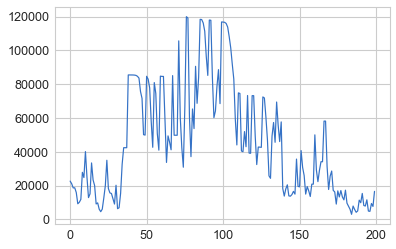

In [54]:
plt.plot(h)

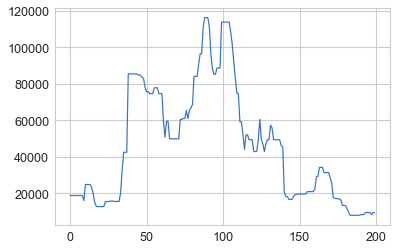

In [55]:
plt.plot(j)

In [45]:
upslopeDivergence(j, 0.5, 3, 3)

1

In [46]:
preliminary_width = np.isin(node_location,watershed_grid_cells)
flow_width = (preliminary_width * da).reshape(mg.shape)

In [47]:
flow_width[flow_width==0] = np.nan

In [48]:
flow_grid_nodes = (preliminary_width * da).reshape(mg.shape)

In [49]:
len(ordered_node_list)

200

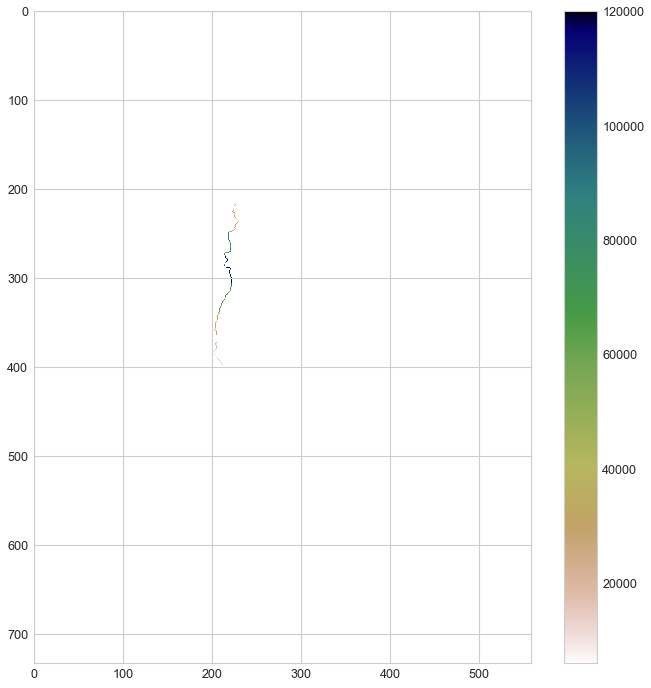

In [50]:
plt.figure(figsize=(12,12))
plt.imshow(flow_width, cmap="gist_earth_r");
plt.colorbar();

In [51]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [52]:
np_array_to_Geotiff('div_flow.tif', input_geotiff, flow_width, input_DEM.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.
